* Should the dataset class inherit from torch.utils.data.Dataset?
* Where to put idx2motif and such?
* should we subdivide all measures (of varying time signitures) the same?
* should we leave "none" as an explicit class?
* how do we boil down version prediction to a single value?
* I split the CNN overlap by half. is this correct?

clip grad error

../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [21,0,0], thread: [644,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [21,0,0], thread: [645,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [640,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [641,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [642,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [643,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [644,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [6,0,0], thread: [645,0,0] Assertion `t >= 0 && t < n_classes` failed.
 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 10/25 [11:39<17:28, 69.91s/it]
Error executing job with overrides: ['cfg.run_name=rnn-adv-version-split']                                                                                                                     
Traceback (most recent call last):
  File "/home/sihun/userdata/projects/ring_leitmotif/train.py", line 168, in main
    trainer.train()
  File "/home/sihun/userdata/projects/ring_leitmotif/train.py", line 82, in train
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
  File "/home/sihun/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/nn/utils/clip_grad.py", line 76, in clip_grad_norm_
    torch._foreach_mul_(grads, clip_coef_clamped.to(device))  # type: ignore[call-overload]
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

In [1]:
import random
from pathlib import Path
import pandas as pd
import pickle
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [15]:
import sys
import math

# Define the variable
my_variable = [1, 2, 3, 4, 5]

# Get the memory size of the variable
memory_size = sys.getsizeof(cqt_mag)

# Convert the memory size to a human-readable format
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

human_readable_size = convert_size(memory_size)

# Print the human-readable memory size
print(human_readable_size)


128.48 MB


In [13]:
from pathlib import Path
import pickle
import pandas as pd
import torch
from tqdm.auto import tqdm
from data_utils import motif2idx, idx2motif, sample_instance_intervals, generate_non_overlapping_intervals, sample_non_overlapping_interval

class LeitmotifDataset:
    def __init__(self, pkl_path:Path, instances_path:Path, duration_sec=15, duration_samples=646):
        self.cqt = {}
        self.instances_gt = {}
        self.samples = []
        self.none_samples = []

        print("Creating dataset...")
        pkl_fns = sorted(list(pkl_path.glob("*.pkl")))
        for fn in tqdm(pkl_fns):
            # Load CQT data
            with open(fn, "rb") as f:
                self.cqt[fn.stem] = torch.tensor(pickle.load(f)).T # (time, n_bins)

            # Create ground truth instance tensors
            self.instances_gt[fn.stem] = torch.zeros((self.cqt[fn.stem].shape[0], 21))
            instances = list(pd.read_csv(instances_path / f"P-{fn.stem.split('_')[0]}/{fn.stem.split('_')[1]}.csv", sep=";").itertuples(index=False, name=None))
            for instance in instances:
                motif = instance[0]
                start = instance[1]
                end = instance[2]
                start_idx = int(round(start * 22050 / 512))
                end_idx = int(round(end * 22050 / 512))
                motif_idx = motif2idx[motif]
                self.instances_gt[fn.stem][start_idx:end_idx, motif_idx] = 1

            # Add "none" class to ground truth
            self.instances_gt[fn.stem][:, -1] = 1 - self.instances_gt[fn.stem][:, :-1].max(dim=1).values
            
            # Sample leitmotif instances
            samples_act = sample_instance_intervals(instances, duration_sec)
            samples_act = [(fn.stem, x[0], int(round(x[1] * 22050 / 512)), int(round(x[1] * 22050 / 512) + duration_samples)) for x in samples_act]
            self.samples.extend(samples_act)

            # Sample non-leitmotif instances
            total_duration = self.cqt[fn.stem].shape[0] * 512 // 22050
            occupied = instances.copy()
            none_intervals = generate_non_overlapping_intervals(instances, total_duration)
            none_samples_act = []
            depleted = False
            while not depleted:
                samp = sample_non_overlapping_interval(none_intervals, duration_sec)
                if samp is None:
                    depleted = True
                else:
                    occupied.append((None, samp[0], samp[1]))
                    none_intervals = generate_non_overlapping_intervals(occupied, total_duration)
                    none_samples_act.append(samp)
            none_samples_act.sort(key=lambda x: x[0])
            none_samples_act = [(fn.stem, int(round(x[0] * 22050 / 512)), int(round(x[0] * 22050 / 512) + duration_samples)) for x in none_samples_act]
            self.none_samples.extend(none_samples_act)

    def __len__(self):
        return len(self.samples) + len(self.none_samples)
    
    def __getitem__(self, idx):
        if idx < len(self.samples):
            fn, _, start, end = self.samples[idx]
            return self.cqt[fn][start:end, :], self.instances_gt[fn][start:end, :]
        else:
            idx -= len(self.samples)
            fn, start, end = self.none_samples[idx]
            return self.cqt[fn][start:end, :], torch.zeros((end - start, 20))

In [14]:
dataset = LeitmotifDataset(Path("data/CQT"), Path("data/LeitmotifOccurrencesInstances/Instances"))

Creating dataset...


  0%|          | 0/33 [00:00<?, ?it/s]

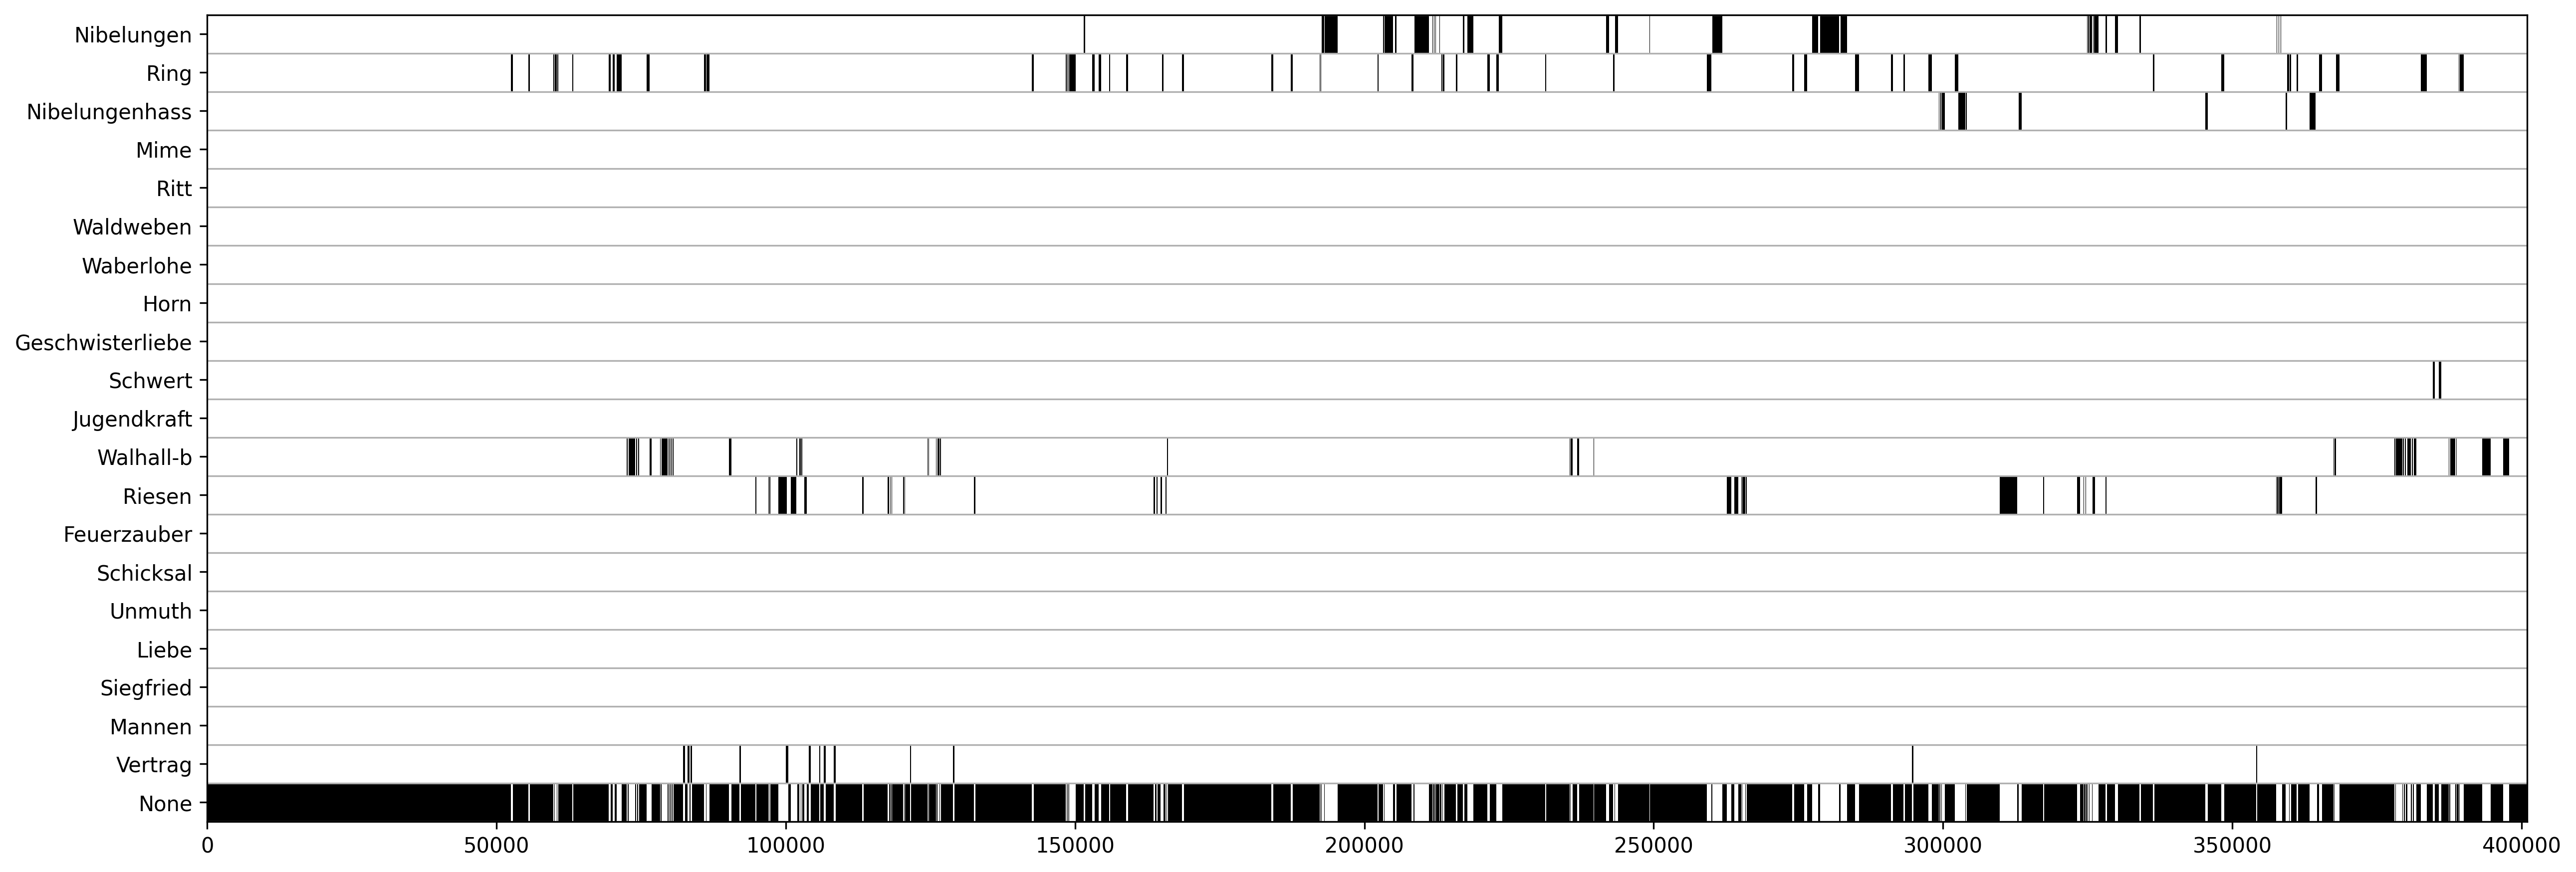

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 7), dpi=300)
im = ax.imshow(dataset.instances_gt["Fu_A"].T, origin="upper", aspect="auto", interpolation="none", cmap="binary")
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.set_yticks(range(21))
ax.set_yticklabels(idx2motif + ["None"])
ax.tick_params(axis="y", which="minor", length=0)
plt.grid(axis="y", which="minor")
plt.show()

In [1]:
from pathlib import Path
from dataset import LeitmotifDataset
dataset = LeitmotifDataset(Path("data/CQT"), Path("data/LeitmotifOccurrencesInstances/Instances"))

Creating dataset...


  0%|          | 0/121 [00:00<?, ?it/s]

In [5]:
dataset.none_samples[49750 - len(dataset.samples)]

('Ka', 'D-1', 208038, 208684)

In [6]:
dataset.cqt['Ka_D-1'].shape

torch.Size([216861, 84])

In [9]:
print(version, motif, start_sec)

Bh_B-3 Feuerzauber 3661


In [4]:
"P-Bö" == "P-Bö"

False

In [3]:
singing_csv_fns = sorted(list(Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing").glob("*.csv")))

In [12]:
singing_csv_fns[18].stem.split('_')[1][6:]

'B-1'

In [17]:
from data_utils import id2version

id = 'Ne'
act = 'B-3'

version = id2version[id]

result_fns = [
    fn for fn in singing_csv_fns
    if fn.stem.split('_')[2] == version and fn.stem.split('_')[1][6:] == act
]

result_fns

[PosixPath('data/WagnerRing_Public/02_Annotations/ann_audio_singing/Wagner_WWV086B-3_Neuhold1993.csv')]

In [18]:
id = 'Ne'

version = id2version[id]

result_fns = [
    fn for fn in singing_csv_fns
    if fn.stem.split('_')[2] == version
]

In [50]:
names = []
for fn in result_fns:
    act_names = pd.read_csv(fn, sep=';')["person"].unique()
    for x in act_names:
        split = [
            x.lower().replace(' und ', ',').replace(' ', '').split(',')
            for x in act_names
        ]
        split = [item for sublist in split for item in sublist]
        names.extend(split)
names = sorted(list(set(names)))

In [51]:
names

['1manne(b)',
 '1manne(b1)',
 '1manne(b2)',
 '1manne(t)',
 '1manne(t2)',
 '2mannen(b)',
 '2mannen(b1)',
 '2mannen(b2)',
 '2mannen(t1)',
 '2mannen(t2)',
 '3mannen(b1)',
 '3mannen(b2)',
 '3mannen(t1',
 '3mannen(t2)',
 '4mannen(b)',
 '4mannen(b1)',
 '4mannen(b2)',
 '4mannen(t1)',
 '6mannen(b1',
 '6mannen(t1',
 '8mannen(t1',
 'achtwalküren',
 'alberich',
 'allemannen(b1',
 'allemannen(t1',
 'b1',
 'b1)',
 'b2)',
 'brünnhilde',
 'derwaldvogel',
 'derwanderer',
 'donner',
 'drittenorn',
 'erda',
 'erstenorn',
 'fafner',
 'fasolt',
 'floßhilde',
 'frauen',
 'freia',
 'fricka',
 'froh',
 'gerhilde',
 'grimgerde',
 'gunther',
 'gutrune',
 'hagen',
 'helmwige',
 'hunding',
 'loge',
 'mannen',
 'mannen(b1',
 'mannen(b1)',
 'mannen(b2',
 'mannen(b2)',
 'mannen(t1',
 'mannen(t1)',
 'mannen(t2',
 'mannen(t2)',
 'mime',
 'ortlinde',
 'rossweisse',
 'schwertleite',
 'siegfried',
 'sieglinde',
 'siegmund',
 'siegrune',
 't1',
 't2',
 't2)',
 'waltraute',
 'wellgunde',
 'woglinde',
 'wotan',
 'zweitenor

In [52]:
len(names)

75

In [1]:
d = {
    'A': [1, 2, 3],
    'DA': [4, 5, 6],
    'B': [7, 8, 9],
    'DB': [10, 11, 12],
}

In [5]:
d1 = {k: v for k, v in d.items() if 'A' in k}

In [13]:
id(d['A']) == id(d1['A'])

True

In [3]:
d.items()

dict_items([('A', [1, 2, 3]), ('DA', [4, 5, 6]), ('B', [7, 8, 9]), ('DB', [10, 11, 12])])

In [4]:
for k, v in d.items():
    print(type(k), type(v))

<class 'str'> <class 'list'>
<class 'str'> <class 'list'>
<class 'str'> <class 'list'>
<class 'str'> <class 'list'>


In [1]:
from dataset import LeitmotifDataset
from pathlib import Path

dataset = LeitmotifDataset(Path("data/CQT"),
                                Path("data/LeitmotifOccurrencesInstances/Instances"),
                                Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing"))

Loading data...


  0%|          | 0/121 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/121 [00:00<?, ?it/s]

In [6]:
dataset.cqt['Bh_A'][0].shape

torch.Size([84])

In [10]:
import torch
t = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
t[-3:14]

tensor([7, 8, 9])

In [11]:
import torch
t = torch.tensor([0, 2, 4, 6, 8, 10, 12, 14, 25])
torch.nn.functional.interpolate(t.unsqueeze(0).unsqueeze(0).float(), size=18, mode='nearest')

tensor([[[ 0.,  0.,  2.,  2.,  4.,  4.,  6.,  6.,  8.,  8., 10., 10., 12., 12.,
          14., 14., 25., 25.]]])

In [16]:
t = torch.randn((10, 3))
y = torch.tensor([1, 2, 3])
y.dim()
# t[3, :] = y
# t

1

# inference test

In [17]:
from pathlib import Path
import torch
import pandas as pd
import hydra
from omegaconf import DictConfig, OmegaConf
from tqdm.auto import tqdm
from dataset import LeitmotifDataset, Subset, collate_fn
from data_utils import id2version
from modules import RNNModel, CNNModel
import constants as C

In [129]:
def infer_rnn(model, cqt):
    leitmotif_out = torch.zeros((cqt.shape[0], 21))
    singing_out = torch.zeros((cqt.shape[0], 1))
    model.eval()
    with torch.inference_mode():
        hidden = None
        for i, x in enumerate(tqdm(cqt, leave=False)):
            x = x.unsqueeze(0).unsqueeze(0)
            lstm_out, h = model.lstm(x, hidden)
            lstm_out = lstm_out.transpose(1, 2)
            lstm_out = model.batch_norm(lstm_out)
            lstm_out = lstm_out.transpose(1, 2)
            leitmotif_pred = model.proj(lstm_out).sigmoid()
            singing_pred = model.singing_mlp(lstm_out)
            hidden = (h[0].detach(), h[1].detach())
            leitmotif_out[i, :] = leitmotif_pred.squeeze()
            singing_out[i, :] = singing_pred.squeeze()
    return leitmotif_out, singing_out

def infer_cnn(model, cqt, duration_samples=646, overlap=236):
    increment = duration_samples - overlap
    leitmotif_out = torch.zeros((cqt.shape[0], 21))
    singing_out = torch.zeros((cqt.shape[0], 1))
    model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, cqt.shape[0], increment), leave=False):
            x = cqt[i:i+duration_samples, :]
            if x.shape[0] <= overlap//2:
                break
            x = x.unsqueeze(0)
            leitmotif_pred, singing_pred, _ = model(x)
            # target and source slice positions
            t_start = i + (overlap//2)
            t_end = min(i + duration_samples - (overlap//2), cqt.shape[0])
            s_start = overlap//2
            s_end = -overlap//2 if t_end < cqt.shape[0] else None
            leitmotif_out[t_start:t_end, :] = leitmotif_pred.squeeze()[s_start:s_end, :]
            singing_out[t_start:t_end] = singing_pred.squeeze(0)[s_start:s_end]
    return leitmotif_out, singing_out

def medfilt(x, k=21):
    assert x.dim() == 1
    k2 = (k - 1) // 2
    y = torch.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i+1)] = x[j:]
        y[-j:, -(i+1)] = x[-1]
    return torch.median(y, dim=1).values

In [113]:
split = 'version'
m = 'CNN'

In [114]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"

dataset = LeitmotifDataset(Path("data/CQT"),
                            Path("data/LeitmotifOccurrencesInstances/Instances"),
                            Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing"))

files = []
cqt = {}
instances_gt = {}
singing_gt = {}
if split == "version":
    cqt = {k: v for k, v in dataset.cqt.items() if k.split("_")[0] in C.VALID_VERSIONS}
    instances_gt = {k: v for k, v in dataset.instances_gt.items() if k.split("_")[0] in C.VALID_VERSIONS}
    singing_gt = {k: v for k, v in dataset.singing_gt.items() if k.split("_")[0] in C.VALID_VERSIONS}
    files = [k for k in cqt.keys()]
elif split == "act":
    cqt = {k: v for k, v in dataset.cqt.items() if k.split("_")[1] in C.VALID_ACTS}
    instances_gt = {k: v for k, v in dataset.instances_gt.items() if k.split("_")[1] in C.VALID_ACTS}
    singing_gt = {k: v for k, v in dataset.singing_gt.items() if k.split("_")[1] in C.VALID_ACTS}
    files = [k for k in cqt.keys()]

model = None
if m == "RNN":
    model = RNNModel()
elif m == "CNN":
    model = CNNModel()
else:
    raise ValueError("Invalid model name")
model.to(DEV)

Loading data...


  0%|          | 0/121 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/121 [00:00<?, ?it/s]

CNNModel(
  (stack1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): DilatedMaxPool2d(
      (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(1, 3), padding=0, dilation=(1, 1), ceil_mode=True)
    )
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(3, 1))
    (8): LeakyReLU(negative_slope=0.2)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(3, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [130]:
fn = files[0]
leitmotif_pred = []
singing_pred = []
cqt_fn = cqt[fn]
cqt_fn = cqt_fn.to(DEV)
if m == "RNN":
    leitmotif_pred, singing_pred = infer_rnn(model, cqt_fn)
elif m == "CNN":
    leitmotif_pred, singing_pred = infer_cnn(model, cqt_fn)

  0%|          | 0/919 [00:00<?, ?it/s]

In [131]:
for i in range(leitmotif_pred.shape[1]):
    leitmotif_pred[:, i] = medfilt(leitmotif_pred[:, i])

In [132]:
version = fn.split("_")[0]
act = fn.split("_")[1]
measures = pd.read_csv(f"data/WagnerRing_Public/02_Annotations/ann_audio_measure/Wagner_WWV086{act}_{id2version[version]}.csv", sep=';').itertuples(index=False, name=None)
subdivision_points = []
last_m = 0
for measure in measures:
    m = measure[0]
    diff = m - last_m
    if last_m == 0:
        last_m = m
        continue
    subdiv_length = diff / 16
    for i in range(16):
        subdiv_point = round((last_m + i * subdiv_length) * 22050 / 512)
        subdivision_points.append(subdiv_point)
    last_m = m

In [133]:
leitmotif_out = torch.zeros(len(subdivision_points)-1, leitmotif_pred.shape[1])
leitmotif_gt = torch.zeros(len(subdivision_points)-1, leitmotif_pred.shape[1])
for i in range(len(subdivision_points)-1):
    start = subdivision_points[i]
    end = subdivision_points[i+1]
    leitmotif_out[i, :] = leitmotif_pred[start:end, :].max(dim=0).values
    leitmotif_gt[i, :] = instances_gt[fn][start:end, :].max(dim=0).values

In [134]:
instances_gt[fn].shape

torch.Size([376721, 21])

In [5]:
import torch
torch.sigmoid(torch.tensor(1)).item()

0.7310585975646973

In [2]:
import torch
import torchaudio

y = torch.load("data/wav-22050/Bh_D-0.pt")
print(y.shape)

torch.Size([46868010])


In [6]:
t = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, n_mels=84)
spec = t(y)
print(spec.shape)

torch.Size([84, 91540])


In [1]:
from dataset import AudioDataset
from pathlib import Path

dataset = AudioDataset(Path("data/wav-22050"),
                       Path("data/LeitmotifOccurrencesInstances/Instances"),
                       Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing"))

Loading data...


  0%|          | 0/121 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/121 [00:00<?, ?it/s]

In [9]:
len(dataset)

59289

In [13]:
len(dataset.samples)

39259

In [17]:
dataset.preview_idx(30656)

('Le',
 'C-1',
 'Schwert',
 tensor([]),
 2625541,
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

: 

In [15]:
from tqdm.auto import tqdm
for i in tqdm(range(len(dataset))):
    if dataset.get_wav(i).shape[0] != 330750:
        print(i, dataset.get_wav(i).shape)

  0%|          | 0/59289 [00:00<?, ?it/s]

30653 torch.Size([330510])
30654 torch.Size([330510])
30655 torch.Size([330510])
30656 torch.Size([330510])


In [6]:
len(dataset)

59278

In [9]:
dataset[59276][0].shape

torch.Size([646, 84])

: 

In [12]:
import random
random.randint(0, 100)

88

In [39]:
random.random()

0.9864968745843848

In [ ]:
-27.2866
======
-29.1 (0.9)
-29.4806 (0.9)
-29.5538 (0.5)
-29.4662 (0.5)
-29.0842 (0.3)


In [24]:
from tqdm.auto import tqdm

mixup_ratio = 0.3

# total = 0
# for i in tqdm(range(1000)):
#     total += torchaudio.functional.loudness(dataset.get_wav(i).unsqueeze(0), 22050)
# print(total / 1000)

# total = 0
# for i in tqdm(range(1000)):
#     idx = random.randint(len(dataset.samples), len(dataset))
#     y = dataset.get_wav(i) * (1 - mixup_ratio) + dataset.get_wav(idx) * mixup_ratio
#     total += torchaudio.functional.loudness(y.unsqueeze(0), 22050)
# print(total / 1000)

total = 0
for i in tqdm(range(1000)):
    idx = random.randint(len(dataset.samples), len(dataset))
    total += torchaudio.functional.loudness(dataset.get_wav(idx).unsqueeze(0), 22050)
print(total / 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(-29.3375)


In [49]:
dataset[0][0].T.shape

torch.Size([646, 84])

In [6]:
import torchaudio
torchaudio.functional.loudness(dataset.get_wav(1).unsqueeze(0), 22050)

tensor(-27.5392)

In [43]:
import pickle
with open("data/CQT/Ke_D-0.pkl", "rb") as f:
    cqt = torch.tensor(pickle.load(f)).T

In [45]:
cqt.shape

torch.Size([92228, 84])

In [9]:
f'{0.1234:.1f}'

'0.1'

In [2]:
gt = torch.load('leitmotif_gt_Kr_A.pt')
pred = torch.load('leitmotif_pred_Kr_A.pt')
pred_medfilt = torch.load('leitmotif_pred_Kr_A_medfilt.pt')
gt_maxed = torch.load('leitmotif_gt_maxed_Kr_A.pt')
pred_maxed = torch.load('leitmotif_pred_maxed_Kr_A.pt')

In [4]:
gt.shape

torch.Size([373166, 21])

In [20]:
gt_maxed.shape

torch.Size([62351, 21])

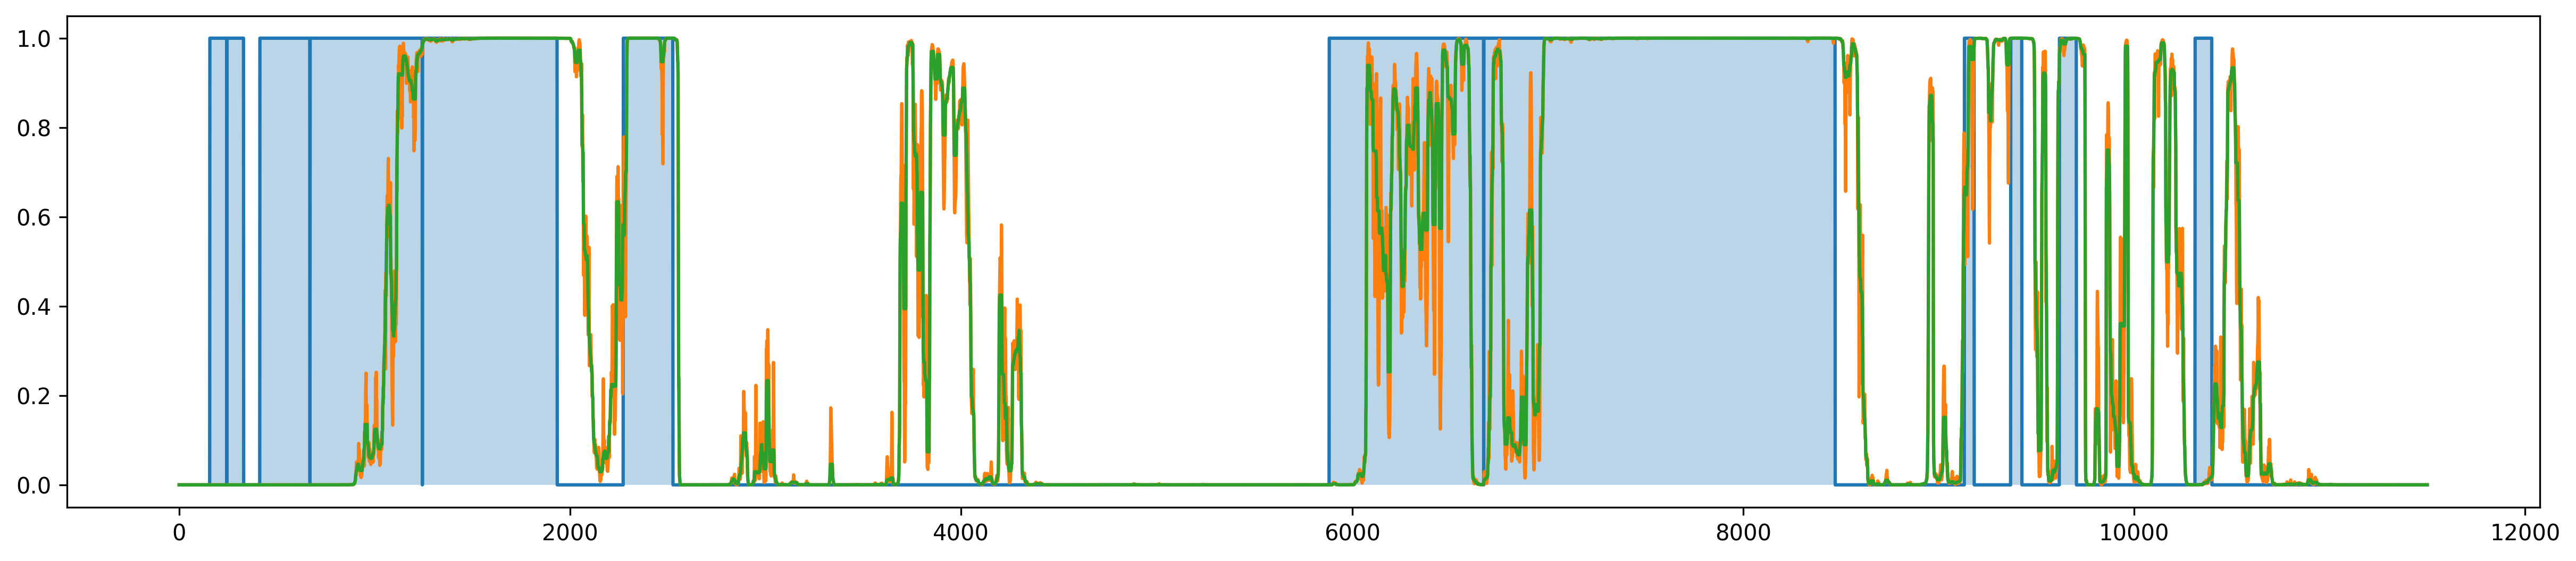

In [33]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt[186500:198000, 0])
ax.fill_between([x for x in range(11500)], gt[186500:198000, 0], alpha=0.3)
ax.plot(pred[186500:198000, 0])
ax.plot(pred_medfilt[186500:198000, 0])


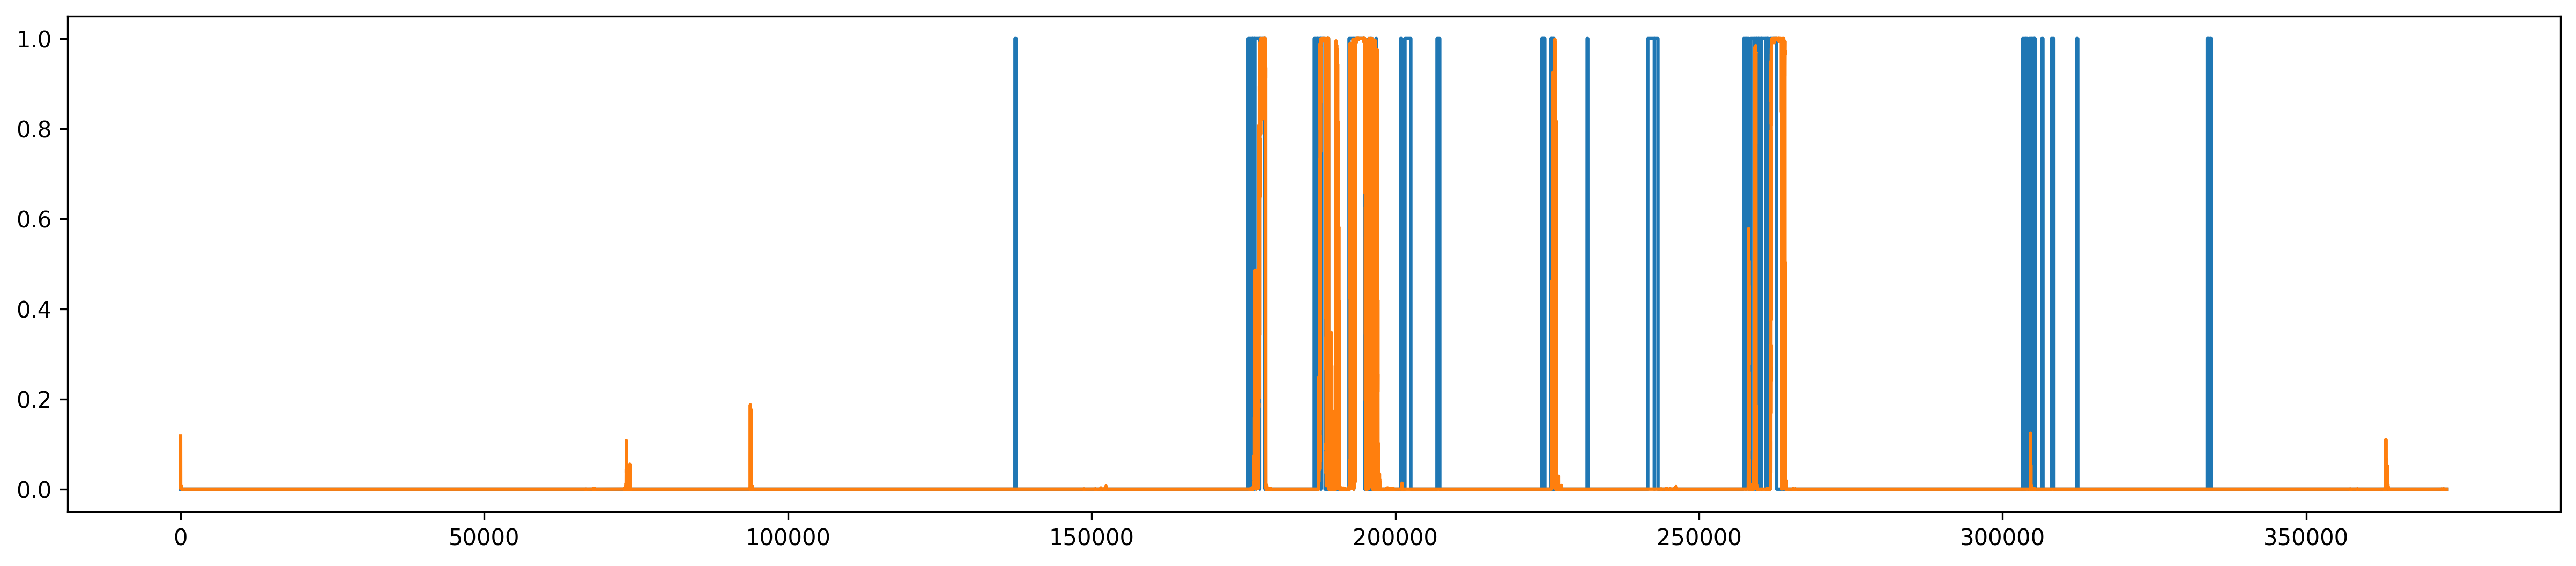

In [35]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt[:, 0])
ax.plot(pred[:, 0])

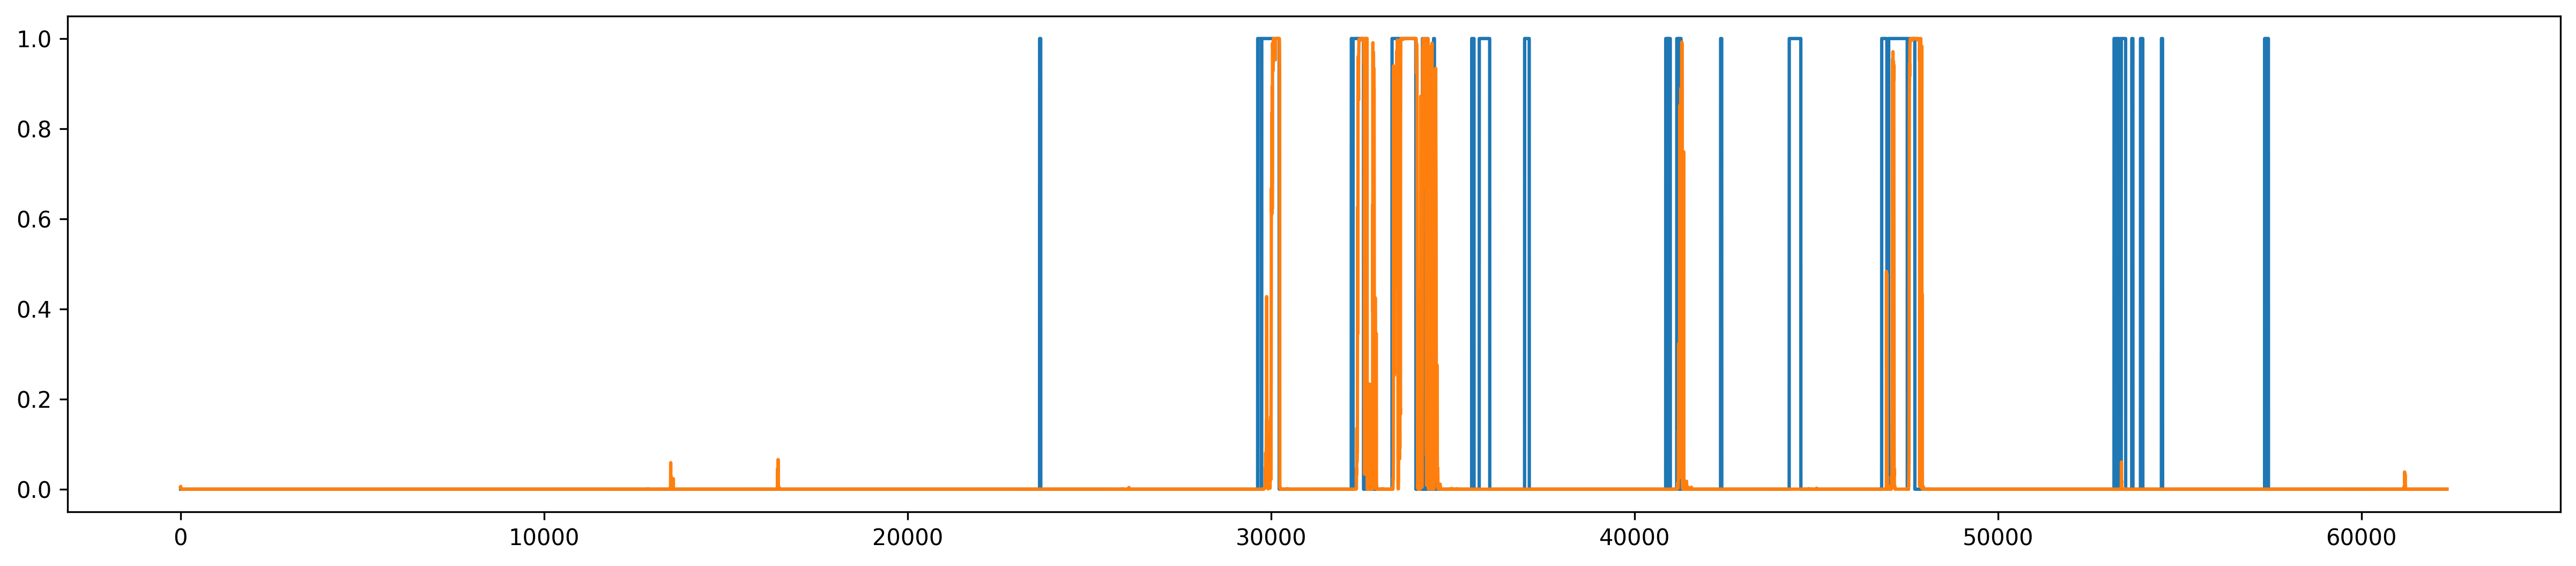

In [34]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt_maxed[:, 0])
ax.plot(pred_maxed[:, 0])
